In [63]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import kagglehub

In [83]:
# Download and load the dataset
path = kagglehub.dataset_download("sobhanmoosavi/us-accidents")
file_path = f"{path}/US_Accidents_March23.csv"

data = pd.read_csv(file_path, nrows=30000)
print("Dataset loaded successfully")

# Feature Engineering: Extract time, month, day, and day of week
data['time'] = pd.to_datetime(data['Start_Time']).dt.hour
data['month'] = pd.to_datetime(data['Start_Time']).dt.month
data['day_of_week'] = pd.to_datetime(data['Start_Time']).dt.dayofweek

# Manual mapping of weather conditions to numeric values
weather_mapping = {
    'Clear': 0,
    'Partly Cloudy': 1,
    'Overcast': 2,
    'Rain': 3,
    'Heavy Rain': 4,
    'Thunderstorm': 5,
    'Fog': 6,
    'Snow': 7,
    'Mist': 8,
    'Hail': 9,
    'Unknown': 10
}

# Apply the manual mapping
data['weather_encoded'] = data['Weather_Condition'].fillna('Unknown').map(weather_mapping)

# Create binary indicators for road conditions
road_conditions = [
    'Traffic_Signal', 'Bump', 'Crossing', 'Give_Way', 'Junction',
    'No_Exit', 'Railway', 'Roundabout', 'Stop', 'Traffic_Calming', 'Turning_Loop'
]
for condition in road_conditions:
    data[condition.lower()] = data[condition].apply(lambda x: 1 if x else 0)

# Create target variable: Accident = Severity 3 or 4
data['Accident'] = data['Severity'].apply(lambda x: 1 if x == 3 or x == 4 else 0)

# Feature selection
selected_features = [
    'Start_Lng', 'Start_Lat', 'time', 'month', 'day_of_week',
    'weather_encoded', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
    'Wind_Speed(mph)', 'Precipitation(in)', 'Visibility(mi)', 'Pressure(in)'
] + [condition.lower() for condition in road_conditions]

# Handle missing values
data[selected_features] = data[selected_features].fillna(0)

X = data[selected_features]
y = data['Accident']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

print(data.head())

Dataset loaded successfully
    ID   Source  Severity           Start_Time             End_Time  \
0  A-1  Source2         3  2016-02-08 05:46:00  2016-02-08 11:00:00   
1  A-2  Source2         2  2016-02-08 06:07:59  2016-02-08 06:37:59   
2  A-3  Source2         2  2016-02-08 06:49:27  2016-02-08 07:19:27   
3  A-4  Source2         3  2016-02-08 07:23:34  2016-02-08 07:53:34   
4  A-5  Source2         2  2016-02-08 07:39:07  2016-02-08 08:09:07   

   Start_Lat  Start_Lng  End_Lat  End_Lng  Distance(mi)  ... crossing  \
0  39.865147 -84.058723      NaN      NaN          0.01  ...        0   
1  39.928059 -82.831184      NaN      NaN          0.01  ...        0   
2  39.063148 -84.032608      NaN      NaN          0.01  ...        0   
3  39.747753 -84.205582      NaN      NaN          0.01  ...        0   
4  39.627781 -84.188354      NaN      NaN          0.01  ...        0   

  give_way junction no_exit railway roundabout stop traffic_calming  \
0        0        0       0       0

In [84]:
# Standardize numerical features
scaler = StandardScaler()
X_train[selected_features] = scaler.fit_transform(X_train[selected_features])
X_test[selected_features] = scaler.transform(X_test[selected_features])

# Train the model using Random Forest (improved model)
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)

rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=2, min_samples_split=5,
                       random_state=42)

In [85]:
# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_train = rf_model.predict(X_train)

# Calculate probabilities for the positive class
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
accuracy1 = accuracy_score(y_train, y_pred_train)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Train Accuracy: {accuracy1 * 100:.2f}%")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Optimal Threshold Adjustment
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")

# Recompute predictions with optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
accuracy_optimal = accuracy_score(y_test, y_pred_optimal)
print(f"Optimal Threshold Accuracy: {accuracy_optimal * 100:.2f}%")

# Display probabilities for class 1
print("Sample Probabilities for Class 1 (Accident):")
print(y_pred_proba[:10])


Test Accuracy: 79.13%
Train Accuracy: 83.27%
ROC-AUC Score: 0.9060
Confusion Matrix:
[[2743  976]
 [ 276 2005]]
Optimal Threshold: 0.6191335498558337
Optimal Threshold Accuracy: 82.82%
Sample Probabilities for Class 1 (Accident):
[0.01441619 0.77561177 0.71118578 0.31791187 0.80221275 0.7665809
 0.5487179  0.41123761 0.05126198 0.31171188]


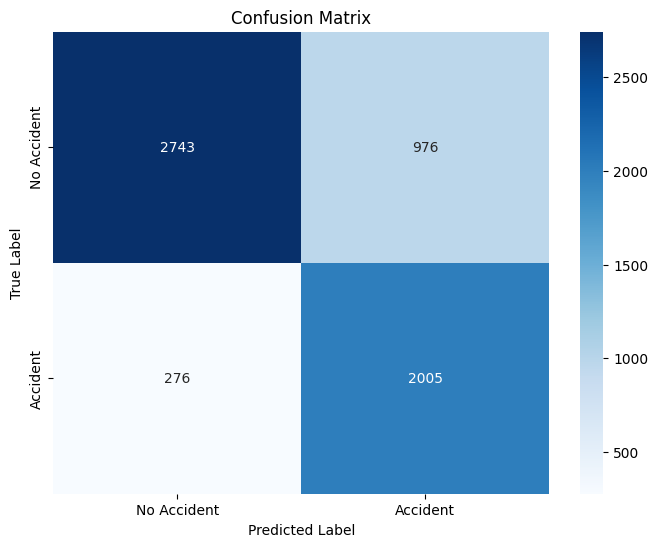

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

class_labels = ["No Accident", "Accident"]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



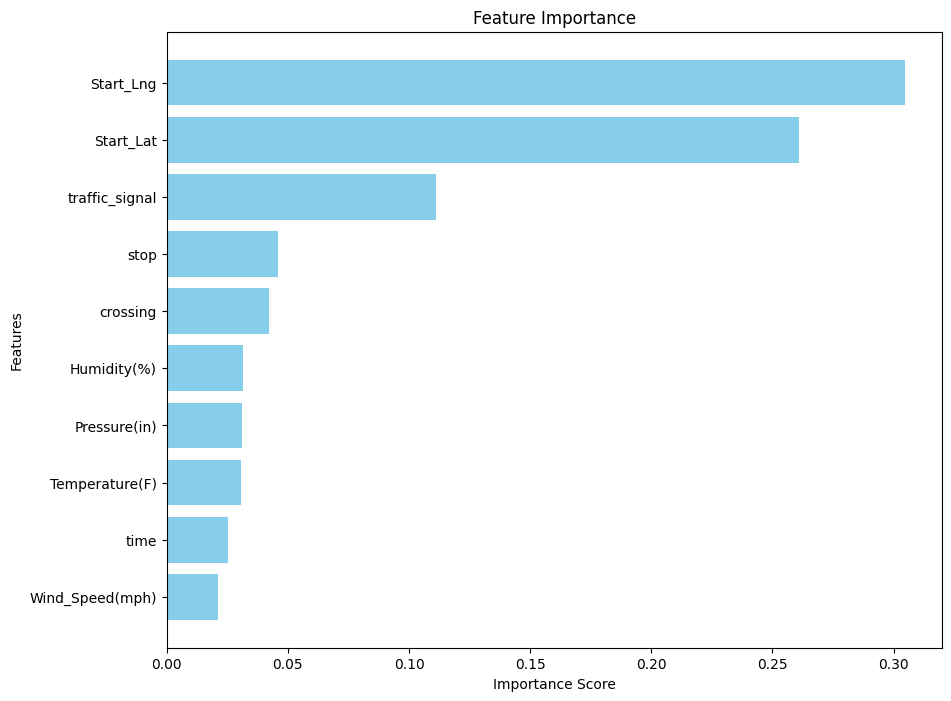

In [90]:
importance = best_model.feature_importances_
indices = np.argsort(importance)[::-1]  # Sort in descending order
sorted_features = [selected_features[i] for i in indices]

plt.figure(figsize=(10, 8))
plt.barh(sorted_features[:10], importance[indices][:10], color='skyblue')
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

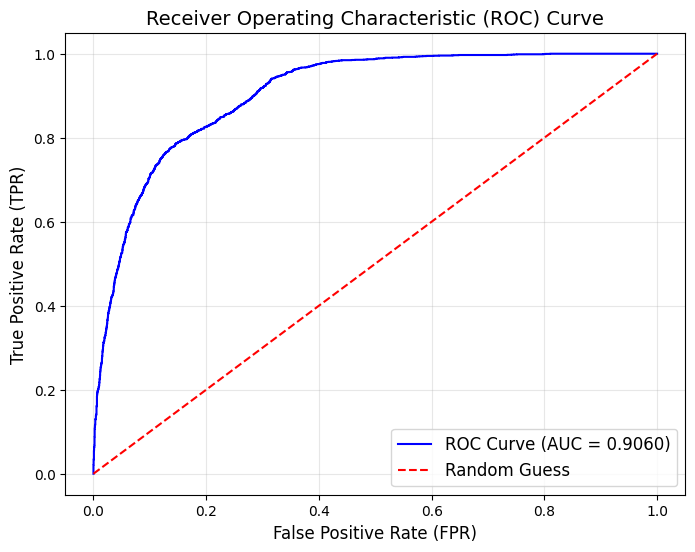

In [91]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

In [11]:
# Create a bad weather condition input (heavy rain, high wind speed, low visibility, etc.)
bad_weather_input = pd.DataFrame({
    'Start_Lng': [-83.0142],  # Random longitude
    'Start_Lat': [39.9174],   # Random latitude (Philadelphia, for example)
    'time': [3],  # Afternoon
    'month': [12],  # December
    'day_of_week': [4],  # Wednesday
    'weather_encoded': [7],  # Heavy Rain
    'Temperature(F)': [30],  # Low temperature (in Fahrenheit)
    'Wind_Chill(F)': [25],  # Wind chill in Fahrenheit
    'Humidity(%)': [40],  # High humidity
    'Wind_Speed(mph)': [30],  # High wind speed (in miles per hour)
    'Precipitation(in)': [2],  # High precipitation
    'Visibility(mi)': [10],  # Low visibility (in miles)
    'Pressure(in)': [29.5],  # Normal pressure
    'traffic_signal': [0],  # Traffic signal present
    'bump': [0],  # Bump present
    'crossing': [0],  # No crossing
    'give_way': [0],  # No give way
    'junction': [0],  # Junction present
    'no_exit': [0],  # No exit
    'railway': [0],  # No railway
    'roundabout': [0],  # No roundabout
    'stop': [0],  # Stop sign present
    'traffic_calming': [0],  # Traffic calming present
    'turning_loop': [0]  # No turning loop
})

# Standardize the input as we did before
bad_weather_input_scaled = scaler.transform(bad_weather_input[selected_features])

# Predict using the trained model
bad_weather_pred_proba = best_model.predict_proba(bad_weather_input_scaled)[:, 1]

print(f"Probability of Accident (Bad Weather): {bad_weather_pred_proba[0] * 100:.2f}%")


Probability of Accident (Bad Weather): 50.50%


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [92]:
import joblib
from google.colab import files

# Save the trained model
joblib.dump(best_model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [93]:
# Download the saved model
files.download('/content/random_forest_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>